# Chapter 3 Q-Learning and SARSA: Mode-Free RL Algorithms

## Example: Web Page Recommendation Problem

In this notebook, we will solve the following web page recommendation problem using Q-learning and SARSA.

### Problem Desciption

A simplified version of the web page recommendation problem [1] can be described as follows. A user enters our website and begins requesting web pages. Considering the web page this user has visited, the system has to predict in what other page the user is probably interested and recommend it to the user. Suppose there are $W$ web pages in total, denoted by page $0$, page $1$, $\ldots$, page $W-1$. At the time when we need to make a recommendation, we have the information of the last web page that the user has visited, denoted by web page $x$, where $x\in\{0,1,\ldots,W-1\}$. We recommend one page out of the $W$ candidate web pages to the user, denoted by web page $a$, where $a\in\{0,1,\ldots,W-1\}$. Then the user may choose to visit the recommended web page $a$ with probability $p(x,a)$ or choose to visit other pages uniformly at random, i.e., visit web page $w\in\{0,\ldots,a-1, a+1,\ldots,W-1\}$ with probability $\frac{1-p(x,a)}{W-1}$. A recommendation is considered successful and a reward $1$ is obtained if the user chooses to visit the recommended page $a$. Otherwise, the reward is $0$. Let $x'$ denote the web page that the user chooses to visit. After the user finishes the visit of web page $x'$, the process goes to the next step and we need to make a recommendation again. An example of the process is shown in the following figure. 

&nbsp;
&nbsp;

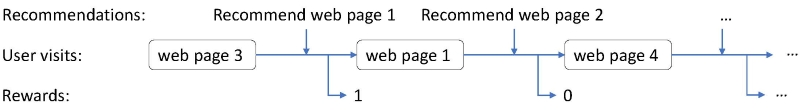

&nbsp;
&nbsp;

Assume that the choice of the user's next visit $x'$ depends only on the last visit $x$ and the recommendation $a$. Assume that the first web page that the user visits follows the uniform distribution.
Let $\alpha$ denote the discount factor for the rewards. The goal of the system is to maximize the discounted total rewards. 

### Formulation

This problem can be formulated into an infinite-horizon discounted DP problem as follows:

- State $x$: the last web page that the user has visited, $x\in\{0,1,\ldots,W-1\}$.
    
- Action $a$: the recommended web page, $a\in\{0,1,\ldots,W-1\}$.
    
- Transition: 
    Let $x_k$ and $a_k$ denote the state and the action at step $k$, respectively.

    \begin{align*}
        \Pr(x_{k+1}=x'|x_k=x,u_k=a) = \begin{cases}
            p(x,a) & \mbox{if $x'=a$}\\
            \frac{1-p(x,a)}{W-1} & \mbox{if $x'\neq a$},
        \end{cases}
    \end{align*}

    where $x,a,x'\in \{0,1,\ldots,W-1\} $.

- Reward: $r(x,a)$: 

    \begin{align*}
        r(x,a)=\begin{cases}
            1 & \mbox{with probability $p(x,a)$}\\
            0 & \mbox{with probability $1-p(x,a)$},
        \end{cases}
    \end{align*}

- Goal: maximize the expected discounted total reward:

    \begin{align*}
        \mathbb{E}\left[\sum_{k=0}^{\infty}\alpha^k r(x_k,a_k)\right].
    \end{align*}

### Value Function and Bellman Eqaution

Let $V^*(x)$ denote the optimal value function for state $x$, defined by

\begin{align*}
    V^*(x)=\max_{\mu} \mathbb{E}\left[\sum_{k=0}^{\infty}\alpha^k r(x_k,\mu(x_k))\left|x_0=x\right.\right],
\end{align*}

where the ``max'' is taken over any stationary policy $\mu$. Then the Bellman equation can be written as

\begin{align*}
V^*(x)= & \max_{\mu}\mathbb{E}\left[r(x,\mu(x))+\alpha {V^*(x')}\right]\\
= & \max_a \left(\mathbb{E}[r(x,a)] + \alpha \sum_{x'} \Pr(x_{k+1}=x'|x_k=x,a_k=a) V^*(x') \right)\\
= & \max_a \left(p(x,a) + \alpha p(x,a) V^*(a) + \alpha \sum_{x'\neq a} \frac{1-p(x,a)}{W-1} V^*(x') \right).
\end{align*}

### Q Function

Let $Q^*(x,a)$ denote the optimal Q-function (action value function), defined by

\begin{align}
Q^*(x,a) = \mathbb{E} \left[r(x,a)\right] + \alpha \mathbb{E} \left[ V^*(x_{t+1}) | x_t=x,a_t=a\right]
\end{align}

&nbsp;

Assume that we are given $W$ and $\alpha$ but we do not know $p(x,a)$ for any $x,a$. Assume that we have access to the user’s visits, the recommendations and the rewards when we recommend web pages to the user. We will solve the problem using model-free algorithms, Q-learning and SARSA.

## Reference
[1] Nima Taghipour, Ahmad Kardan, and Saeed Shiry Ghidary. Usage-based web recommendations: a reinforcement learning approach. In Proceedings of the 2007 ACM conference on Recommender systems, pages 113–120, 2007.


In [ ]:
# Import packages. Run this cell.

import numpy as np

## Codes

Problem setting:
- `W`: the number of web pages, i.e., $W$.
- `alpha`: the discount factor $\alpha$.
- `p`: a numpy array with shape `(W, W)`. `p[x,a]` represents the probability of accepting the recommendation $a$ when the state is $x$, i.e., $p(x,a)$.

### Q-learning

In this part, we will use Q-learing to solve the problem.

The python class `QLearningAgent` implements the Q-learning algorithm.

The function `select_action` in the class will be called each step of recommendation and returns a recommended web page.
- The input `state` is the current state, i.e., the last web page that the user visited.
- The output `action` is the web page that the agent (system) recommends, which is a value from $0$ to $W-1$.

The function `train` in the class will be called each step after the agent makes a recommendation, receives a reward, and observes the next state (next visited page). It is used for the update of the Q table.
- The input `cur_state` is the current state.
- The input `cur_action` is the current action.
- The input `reward` is the reward received.
- The input `next_state` is the next state observed.

In [ ]:
class QLearningAgent:

    def __init__(self, W, alpha, seed=None):
        # problem setting
        self.W = W
        self.alpha = alpha

        # The following are recommended hyper-parameters.
        # Learning rate can be set to 1000/(t+1000), where t is the number of steps that the agent has been trained.
        # Minimum learning rate: 0.001
        # Epsilon for exploration can be set to 1000/(t+1000)
        self.trained_steps = 0
        self.q_table = np.zeros((W, W))  # The Q table.
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        self.min_learning_rate = 0.001
        self.epsilon = 1000 / (self.trained_steps + 1000) # For the epsilon-greedy exploration. 
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        
        
    def select_action(self, state):
        """
        This function returns a recommendation.
        Args:
            state: the state in the current step
        Returns:
            action: a web page that the agent recommends
        """
        # We use epsilon-greedy for exploration. 
        # With probability self.epsilon, choose an action uniformly at random; 
        # Otherwise, choose a greedy action based on self.q_table.
        if self.rng.random() < self.epsilon:
            action = self.rng.choice(W)
        else:
            action = np.argmax(self.q_table[state, :])
        
        return action
    
    def train(self, cur_state, cur_action, reward, next_state):
        """
        This function is used for the update of the Q table
        Args:
            - cur_state: the current state
            - cur_action: the current action
            - reward: the reward received
            - next_state: the next state observed
        """

        self.q_table[cur_state, cur_action] = (1 - self.learning_rate) * self.q_table[cur_state, cur_action] + self.learning_rate * (reward + self.alpha * np.max(self.q_table[next_state, :]))
        
        # Update epsilon and learning rate
        self.trained_steps += 1
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        if self.learning_rate < self.min_learning_rate:
            self.learning_rate = self.min_learning_rate
        self.epsilon = 1000 / (self.trained_steps + 1000)

The following is the code for the numerical experiment. Let $W=10$, $\alpha=0.9$. We will fix a randomly chosen $p$. We let the agent learn online for 100000 steps. We evaluate the learning agent once every 5000 steps. For each evaluation, we conduct a separate simulation of the problem with 100 runs and each run contains 100 steps. 

In [ ]:
# Problem parameters
rng = np.random.default_rng(seed=0)
W = 10
alpha = 0.9
p = rng.uniform(size=(W, W))
num_runs_eval = 100
num_steps_per_run_eval = 100
eval_once_every = 5000
num_total_steps = 100000

# Evaluation function
def evaluation(W, alpha, p, agent, num_runs_eval, num_steps_per_run_eval):
    rng = np.random.default_rng()
    avg_reward = 0.0
    for n in range(num_runs_eval):
        total_reward = 0.0
        state = rng.integers(low=0, high=W)
        for step in range(num_steps_per_run_eval):
            action = agent.select_action(state)
            if rng.random() < p[state, action]:
                reward = 1.0
                next_state = action
            else:
                reward = 0.0
                next_state = rng.choice(np.delete(np.arange(W), action))
            total_reward = total_reward + (alpha ** step) * reward
            state = next_state
        avg_reward += total_reward
    avg_reward = avg_reward / num_runs_eval
    return avg_reward

# Learning using Q-learning
agent = QLearningAgent(W, alpha)
state = rng.integers(low=0, high=W)
for step in range(num_total_steps):
    action = agent.select_action(state)
    if rng.random() < p[state, action]:
        reward = 1.0
        next_state = action
    else:
        reward = 0.0
        next_state = rng.choice(np.delete(np.arange(W), action))
    agent.train(state, action, reward, next_state)
    state = next_state
    if step % eval_once_every == 0:
        avg_reward = evaluation(W, alpha, p, agent, num_runs_eval, num_steps_per_run_eval)
        print("Step %d: Evaluated Reward: %.3f" % (step, avg_reward))

We can compare the performance of Q-learning with that of the optimal policy, which can be obtained by policy iteration.

In [ ]:
def policy_iteration(W, alpha, p):
    """
    Implement the policy iteration algorithm
    Args:
        W: the number of web pages.
        alpha: the discount factor.
        p: a numpy array with shape (W, W). p[x,a] represents the probability of accepting the recommendation a when the state is x, i.e., p(x,a).
    Returns:
        mu: the optimal policy obtained from the policy iteration algorithm.
            mu is a numpy array with size W.
    """
    mu = np.zeros((W,), dtype=int)
    mu_pre = np.zeros((W,), dtype=int)
    error_count = W
    while error_count > 0:
        # solve the linear matrix equation Ax=b induced by Bellman equation for policy mu_pre
        b = p[np.arange(W), mu_pre]
        A = np.array([[-alpha * b[row] if col == mu_pre[row] else -alpha * (1 - b[row]) / (W - 1) for col in range(W)] for row in range(W)]) + np.identity(W)
        V = np.linalg.solve(A, b)
        # update the policy
        for x in range(W):
            q_x = np.zeros((W,))
            for a in range(W):
                q_x[a] = p[x,a] + alpha * p[x,a] * V[a] + alpha * (1 - p[x, a]) / (W - 1) * (np.sum(V) - V[a])
            mu[x] = np.argmax(q_x)
        error_count = np.sum((mu != mu_pre))
        mu_pre = mu.copy()
    return mu

In [ ]:
## Evaluation of policy iteration
mu_by_policy_iter = policy_iteration(W, alpha, p)
avg_reward_policy_iter = 0.0
for n in range(num_runs_eval):
    total_reward = 0.0
    state = rng.integers(low=0, high=W)
    for step in range(num_steps_per_run_eval):
        action = mu_by_policy_iter[state]
        if rng.random() < p[state, action]:
            reward = 1.0
            next_state = action
        else:
            reward = 0.0
            next_state = rng.choice(np.delete(np.arange(W), action))
        total_reward = total_reward + (alpha ** step) * reward
        state = next_state
    avg_reward_policy_iter += total_reward
avg_reward_policy_iter = avg_reward_policy_iter / num_runs_eval
print("Policy Iteration: The total discounted reward averaged over %d runs:\n%.3f" % (num_runs_eval, avg_reward_policy_iter))

### SARSA

In this part, we will use SARSA to solve the problem.

The python class `SARSAAgent` implements the SARSA algorithm.

The function `select_action` in the class will be called each step of recommendation and returns a recommended web page.
- The input `state` is the current state, i.e., the last web page that the user visited.
- The output `action` is the web page that the agent (system) recommends, which is a value from $0$ to $W-1$.

The function `train` in the class will be called each step after the agent makes a recommendation, receives a reward, and observes the next state (next visited page). It is used for the update of the Q table.

- pre_state: the state in the previous step
- pre_action: the action in the previous step
- pre_reward: the reward received in the previous step.
- cur_state: the state in the current step
- cur_action: the action in the current step

In [ ]:
class SARSAAgent:

    def __init__(self, W, alpha, seed=None):
        # problem setting
        self.W = W
        self.alpha = alpha

        # The following are recommended hyper-parameters.
        # Learning rate can be set to 1000/(t+1000), where t is the number of steps that the agent has been trained.
        # Minimum learning rate: 0.001
        # Epsilon for exploration can be set to 1000/(t+1000)
        self.trained_steps = 0
        self.q_table = np.zeros((W, W))  # The Q table.
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        self.min_learning_rate = 0.001
        self.epsilon = 1000 / (self.trained_steps + 1000) # For the epsilon-greedy exploration. 
        if seed is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = np.random.default_rng(seed)
        
        
    def select_action(self, state):
        """
        This function returns a recommendation.
        Args:
            state: the state in the current step
        Returns:
            action: a web page that the agent recommends
        """
        # We use epsilon-greedy for exploration. 
        # With probability self.epsilon, choose an action uniformly at random; 
        # Otherwise, choose a greedy action based on self.q_table.
        if self.rng.random() < self.epsilon:
            action = self.rng.choice(W)
        else:
            action = np.argmax(self.q_table[state, :])
        
        return action
    
    def train(self, pre_state, pre_action, pre_reward, cur_state, cur_action):
        """
        This function is used for the update of the Q table
        Args:
            - pre_state: the state in the previous step
            - pre_action: the action in the previous step
            - pre_reward: the reward received in the previous step.
            - cur_state: the state in the current step
            - cur_action: the action in the current step
        """
        self.q_table[pre_state, pre_action] = (1 - self.learning_rate) * self.q_table[pre_state, pre_action] + self.learning_rate * (pre_reward + self.alpha * self.q_table[cur_state, cur_action])
        
        # Update epsilon and learning rate
        self.trained_steps += 1
        self.learning_rate = 1000 / (self.trained_steps + 1000)
        if self.learning_rate < self.min_learning_rate:
            self.learning_rate = self.min_learning_rate
        self.epsilon = 1000 / (self.trained_steps + 1000)

The following is the code for the numerical experiment. We consider the same setting as that of Q-learning.

In [ ]:
# Learning using SARSA
agent = SARSAAgent(W, alpha)
state = rng.integers(low=0, high=W)
pre_state = None
pre_action = None
pre_reward = None
for step in range(num_total_steps):
    action = agent.select_action(state)
    if rng.random() < p[state, action]:
        reward = 1.0
        next_state = action
    else:
        reward = 0.0
        next_state = rng.choice(np.delete(np.arange(W), action))
    if 1 <= step < num_total_steps:
        agent.train(pre_state, pre_action, pre_reward, state, action)
    pre_state = state
    pre_action = action
    pre_reward = reward
    state = next_state
    if step % eval_once_every == 0:
        avg_reward = evaluation(W, alpha, p, agent, num_runs_eval, num_steps_per_run_eval)
        print("Step %d: Evaluated Reward: %.3f" % (step, avg_reward))